# Audio model pruning
## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from joblib import dump
import matplotlib.pyplot as plt

from audio_model_training import get_audio_model, get_audio_datasets, CLASS_NAMES, NCLASSES
from audio_model_optimization import *

## Parámetros
Se establecen los parámetros para la optimización.

In [2]:
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/audio"
original_model_name = "ExtAudioDataModel"
checkpoint_dir = f"{saved_models_dir}/tensorflow/checkpoints"
original_checkpoint_path = f"{checkpoint_dir}/{original_model_name}.hdf5"
label_index_dir = f"{saved_models_dir}/label index mappings"

model_name = f"{original_model_name}Prun"
checkpoint_path = f"{checkpoint_dir}/{model_name}.hdf5"

data_dir = f"{project_dir}/samples/external/audio/train"
log_dir = f"{saved_models_dir}/summaries/{model_name}"
model_dir = f"{saved_models_dir}/tensorflow/{model_name}"

validation_percentage = 20.
initial_learning_rate = 0.001
decay = (initial_learning_rate / PRUNING_EPOCHS) * 1.5

## Carga de datos
Se cargan los mismos datasets de entrenamiento y validación que se han usado en el entrenamiento.

In [3]:
train_dataset, validation_dataset = get_audio_datasets(data_dir, validation_percentage)

class_list_text = "Classes:"
for index, name in enumerate(CLASS_NAMES):
    class_list_text += f"\n\t{index}: {name}"

print(class_list_text)
with open(f"{label_index_dir}/{model_name}.txt", "wt") as text_file:
    text_file.write(class_list_text)

dump(CLASS_NAMES, f"{label_index_dir}/{model_name}.joblib")

Se usarán 12924 muestras:
	- Train: 10340
	- Validation: 2584
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Classes:
	0: no
	1: silence
	2: unknown
	3: yes


['/home/daniel/PycharmProjects/tfg-tinyml/saved models/audio/label index mappings/ExtAudioDataModelPrun.joblib']

## Pruning y clustering
Se aplica pruning. Primero se carga el modelo original y luego se aplica el pruning o el clustering en función de los
parámetros indicados.

In [4]:
model = get_audio_model((129, 124, 1), model_name, train_dataset)

model.load_weights(original_checkpoint_path)

def lr_time_based_decay(epoch: int, lr: float) -> float:
    """
    Callback function que reduce el learning rate conforme avanza el entrenamiento.
    Args:
        epoch:  int que representa el epoch del entrenamiento que se va a realizar a continuación.
        lr:     float con el learning rate del último epoch.

    Returns:
        float con el nuevo learning rate
    """
    return lr * 1 / (1 + decay * epoch)

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy',
                                            mode='max', save_best_only=True, verbose=1)

early_stopping_callback = EarlyStopping(monitor='val_loss', verbose=1, patience=PATIENCE)

callbacks = [LearningRateScheduler(lr_time_based_decay, verbose=1), model_checkpoint_callback, early_stopping_callback]

model = apply_pruning(model)
callbacks.append(tfmot.sparsity.keras.UpdatePruningStep())
callbacks.append(tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=PRUNING_EPOCHS,
    callbacks=callbacks
)

model.load_weights(checkpoint_path)

/home/daniel/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "ExtAudioDataModelPrun"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 13, 12, 8)         1290      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 6, 6, 8)           1         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 8)           0         
_________________________________________________________________
prune_low_magnitude_flatten  (None, 288)               1         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 4)       

## Visualización de historial de entrenamiento

Se visualiza accuracy y loss de training y validation.

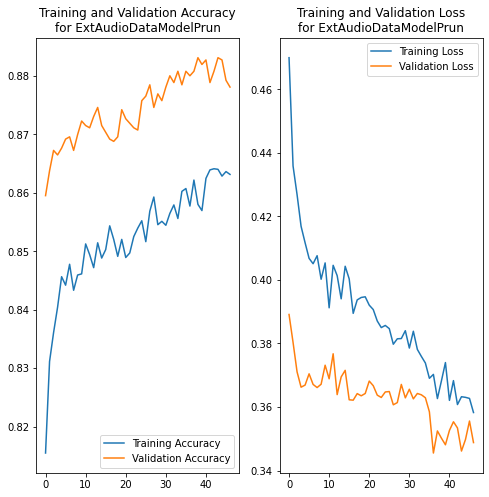

In [5]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title(f"Training and Validation Accuracy\nfor {model_name}")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title(f"Training and Validation Loss\nfor {model_name}")

plt.savefig(f"{log_dir}/{model_name}_training_data.jpg")

plt.show()

## Guardar modelo
Guardamos el modelo entrenado para poder reutilizarlo en el futuro.

In [6]:
tf.keras.models.save_model(model, model_dir)

INFO:tensorflow:Assets written to: /home/daniel/PycharmProjects/tfg-tinyml/saved models/audio/tensorflow/ExtAudioDataModelPrun/assets


INFO:tensorflow:Assets written to: /home/daniel/PycharmProjects/tfg-tinyml/saved models/audio/tensorflow/ExtAudioDataModelPrun/assets
